In [1]:
# Necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras import layers

sns.set_theme()

# Data preparation

In [2]:
# importing data

df = pd.read_csv("HIGGS_8K.csv", header=None)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.0,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,0.0,1.630428,0.404143,0.401026,2.722409,0.355644,1.362199,0.015818,-1.174111,0.0,...,0.387635,1.596321,1.550981,0.859235,0.827233,0.995416,0.764766,0.520597,0.850413,0.929865
2,1.0,0.326305,-0.797735,0.223471,1.248234,-1.427857,0.923767,-0.278280,-0.470052,0.0,...,-0.426866,1.153501,0.000000,0.887944,0.924601,0.987189,0.854094,0.385013,0.789912,0.724627


In [3]:
# checking the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8001 entries, 0 to 8000
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       8001 non-null   float64
 1   1       8001 non-null   float64
 2   2       8001 non-null   float64
 3   3       8001 non-null   float64
 4   4       8001 non-null   float64
 5   5       8001 non-null   float64
 6   6       8001 non-null   float64
 7   7       8001 non-null   float64
 8   8       8001 non-null   float64
 9   9       8001 non-null   float64
 10  10      8001 non-null   float64
 11  11      8001 non-null   float64
 12  12      8001 non-null   float64
 13  13      8001 non-null   float64
 14  14      8001 non-null   float64
 15  15      8001 non-null   float64
 16  16      8001 non-null   float64
 17  17      8001 non-null   object 
 18  18      8001 non-null   float64
 19  19      8001 non-null   float64
 20  20      8001 non-null   float64
 21  21      8001 non-null   float64
 22  

In [4]:
# fixing the columns 0 and 17 datatype

df.iloc[0,17] = 0.
df[17] = df[17].astype(np.float64)
df[0] = df[0].astype(np.bool_)
print(df[17].dtype)
print(df[0].dtype)

float64
bool


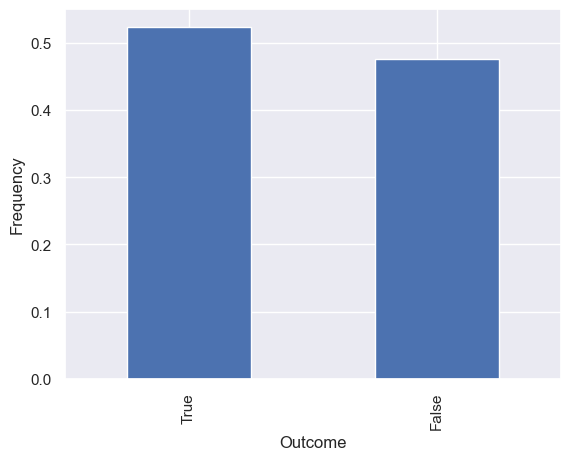

In [5]:
# check the frequency of classes in the target column (0)

df[0].value_counts(normalize = True).plot.bar()
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.show()

In [6]:
# Low-level and High-level input features

df_ll = df.iloc[:,1:21+1]
df_hl = df.iloc[:,22:28+1]

# target
target = df.iloc[:,0]
target.head(3)

0     True
1    False
2     True
Name: 0, dtype: bool

In [7]:
# Data standardization

ss_df_ll = StandardScaler().fit_transform(df_ll)
ss_df_hl = StandardScaler().fit_transform(df_hl)

In [8]:
# split data

xll_train, xll_test, yll_train, yll_test = train_test_split(ss_df_ll, target, test_size=0.25)
xhl_train, xhl_test, yhl_train, yhl_test = train_test_split(ss_df_hl, target, test_size=0.25)

# We construct a parameter grid to find the best model

In [9]:
# First model - ExtraTreesClassifier

ETC_param_grid = {
    'max_depth' : [6, 12, None],
    'min_samples_split' : [2, 3, 4],
    'min_samples_leaf' : [1, 5, 25],
    'max_features' : ['sqrt', 'log2', None]}

ETC = ExtraTreesClassifier()

# Low-level input features
ETC_grid_search_ll = GridSearchCV(ETC, param_grid=ETC_param_grid, 
                                  cv=KFold(n_splits=10, shuffle=True), 
                                  scoring='roc_auc', n_jobs=-1)
ETC_grid_search_ll.fit(xll_train, yll_train)

# High-level input features
ETC_grid_search_hl = GridSearchCV(ETC, param_grid=ETC_param_grid, 
                                  cv=KFold(n_splits=10, shuffle=True), 
                                  scoring='roc_auc', n_jobs=-1)
_ = ETC_grid_search_hl.fit(xhl_train, yhl_train)

In [10]:
# Second model - KNeighborsClassifier

KNC_param_grid = {
    'n_neighbors' : [5, 20, 35],
    'weights' : ["uniform", "distance"],
    'algorithm' : ["ball_tree", "kd_tree", "brute"],
    'leaf_size' : [10, 30, 50]}

KNC = KNeighborsClassifier()

# Low-level input features
KNC_grid_search_ll = GridSearchCV(KNC, param_grid=KNC_param_grid, 
                                  cv=KFold(n_splits=10, shuffle=True), 
                                  scoring='roc_auc', n_jobs=-1)
KNC_grid_search_ll.fit(xll_train, yll_train)

# High-level input features
KNC_grid_search_hl = GridSearchCV(KNC, param_grid=KNC_param_grid, 
                                  cv=KFold(n_splits=10, shuffle=True), 
                                  scoring='roc_auc', n_jobs=-1)
_ = KNC_grid_search_hl.fit(xhl_train, yhl_train)

# We rank our estimators based on their performance

In [11]:
ETC_grid_search_results_ll = pd.DataFrame(ETC_grid_search_ll.cv_results_)
ETC_grid_search_results_ll.sort_values(by='rank_test_score').iloc[:,-3:].head(3)

,mean_test_score,std_test_score,rank_test_score
48,0.657445,0.024340,1
75,0.657052,0.018684,2
49,0.656184,0.020707,3


In [12]:
ETC_grid_search_results_hl = pd.DataFrame(ETC_grid_search_hl.cv_results_)
ETC_grid_search_results_hl.sort_values(by='rank_test_score').iloc[:,-3:].head(3)

,mean_test_score,std_test_score,rank_test_score
76,0.768345,0.016371,1
77,0.768049,0.016160,2
75,0.767558,0.016760,3


In [13]:
KNC_grid_search_results_ll = pd.DataFrame(KNC_grid_search_ll.cv_results_)
KNC_grid_search_results_ll.sort_values(by='rank_test_score').iloc[:,-3:].head(3)

,mean_test_score,std_test_score,rank_test_score
53,0.615021,0.018893,1
17,0.615021,0.018893,1
29,0.615021,0.018893,1


In [14]:
KNC_grid_search_results_hl = pd.DataFrame(KNC_grid_search_hl.cv_results_)
KNC_grid_search_results_hl.sort_values(by='rank_test_score').iloc[:,-3:].head(3)

,mean_test_score,std_test_score,rank_test_score
53,0.751241,0.014185,1
23,0.751241,0.014185,1
5,0.751241,0.014185,1


In [15]:
# the best models

ETC_ll = ETC_grid_search_ll.best_estimator_
ETC_hl = ETC_grid_search_hl.best_estimator_
KNC_ll = KNC_grid_search_ll.best_estimator_
KNC_hl = KNC_grid_search_hl.best_estimator_

# Neural network model

In [16]:
# We construct a function to generate a loss versus time graph
# and a class which improves our appearance when training the model

def plot_loss(history, title):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title(title)
    plt.legend()
    
class EpochDots(tf.keras.callbacks.Callback):
    """A simple callback that prints a "." every epoch, with occasional reports.
    
    Args:
        report_every: How many epochs between full reports
        dot_every: How many epochs between dots.
    """

    def __init__(self, report_every=100, dot_every=1):
        self.report_every = report_every
        self.dot_every = dot_every

    def on_epoch_end(self, epoch, logs):
        if epoch % self.report_every == 0:
            print()
            print('Epoch: {:d}, '.format(epoch), end='')
            for name, value in sorted(logs.items()):
                print('{}:{:0.4f}'.format(name, value), end=',  ')
            print()

        if epoch % self.dot_every == 0:
            print('.', end='', flush=True)

In [17]:
# We define some settings we need

num_epochs = 1000
group_epochs = 200
batch_size = 100

# Stop due to convergence
early_stop = [EpochDots(group_epochs, 2),
              tf.keras.callbacks.EarlyStopping(patience=group_epochs)]

In [18]:
# Network architecture 
# for low-level features
ANN_ll = tf.keras.Sequential([
    layers.Input(shape=(21,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(.5),
    layers.Dense(1)], name='ANN_ll')

ANN_ll.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.AUC(name='auc')])

ANN_ll.summary()

Model: "ANN_ll"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,665 (22.13 KB)

 Trainable params: 5,665 (22.13 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Network architecture 
# for high-level features
ANN_hl = tf.keras.Sequential([
    layers.Input(shape=(7,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(.5),
    layers.Dense(1)], name='ANN_hl')

ANN_hl.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.AUC(name='auc')])

ANN_hl.summary()

Model: "ANN_hl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 64)                  │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,769 (18.63 KB)

 Trainable params: 4,769 (18.63 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, auc:0.4937,  loss:4.9450,  val_auc:0.5098,  val_loss:0.8713,  
....................................................................................................
Epoch: 200, auc:0.5503,  loss:0.6974,  val_auc:0.5872,  val_loss:0.6844,  
....................................................................................................
Epoch: 400, auc:0.6755,  loss:0.6454,  val_auc:0.6369,  val_loss:0.6660,  
....................................................................................................
Epoch: 600, auc:0.7038,  loss:0.6305,  val_auc:0.6349,  val_loss:0.6614,  
....................................................................................................
Epoch: 800, auc:0.6944,  loss:0.6498,  val_auc:0.6344,  val_loss:0.6739,  
.........................................



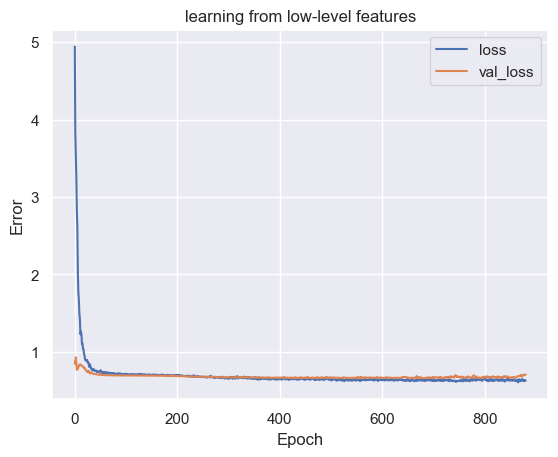

In [20]:
# checking the model for overfitting and learning ability (low-level features)

history_ll = ANN_ll.fit(
    xll_train, 
    yll_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.25,
    shuffle=True,
    verbose=0,
    callbacks=early_stop)

print('\n')
plot_loss(history_ll, 'learning from low-level features')


Epoch: 0, auc:0.4737,  loss:2.4966,  val_auc:0.5443,  val_loss:0.8327,  
....................................................................................................
Epoch: 200, auc:0.7298,  loss:0.6209,  val_auc:0.7729,  val_loss:0.5855,  
....................................................................................................
Epoch: 400, auc:0.7493,  loss:0.6097,  val_auc:0.7771,  val_loss:0.5769,  
....................................................................................................
Epoch: 600, auc:0.7561,  loss:0.5899,  val_auc:0.7810,  val_loss:0.5784,  
...............................



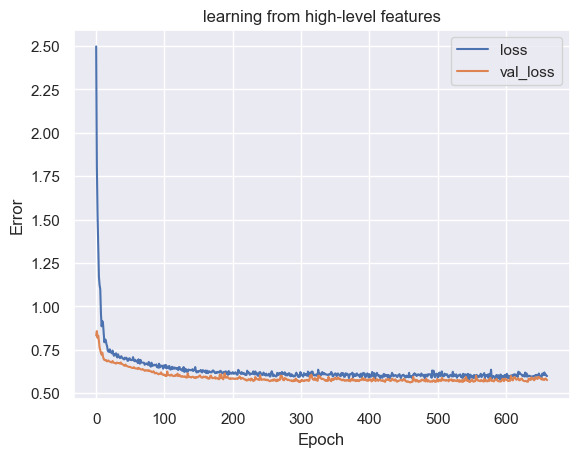

In [21]:
# checking the model for overfitting and learning ability (high-level features)

history_hl = ANN_hl.fit(
    xhl_train, 
    yhl_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.25,
    shuffle=True,
    verbose=0,
    callbacks=early_stop)

print('\n')
plot_loss(history_hl, 'learning from high-level features')

# Comparing the models

In [22]:
print('Learning from low-level features')
print("Area under the curve")
print(f'ETC = {roc_auc_score(yll_test, ETC_ll.predict(xll_test)):.3f}')
print(f'KNC = {roc_auc_score(yll_test, KNC_ll.predict(xll_test)):.3f}')
print(f'ANN = {roc_auc_score(yll_test, ANN_ll.predict(xll_test, verbose=0)):.3f}')

Learning from low-level features
Area under the curve
ETC = 0.601
KNC = 0.564
ANN = 0.633


In [23]:
print('Learning from low-level features')
print("Area under the curve")
print(f'ETC = {roc_auc_score(yhl_test, ETC_hl.predict(xhl_test)):.3f}')
print(f'KNC = {roc_auc_score(yhl_test, KNC_hl.predict(xhl_test)):.3f}')
print(f'ANN = {roc_auc_score(yhl_test, ANN_hl.predict(xhl_test, verbose=0)):.3f}')

Learning from low-level features
Area under the curve
ETC = 0.701
KNC = 0.669
ANN = 0.770
